# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown==3.3.1`
- 코랩에는 설치 되어 있음.

In [ ]:
#!pip install gdown

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)

#다음과 같이 데이터 셋을 다운받을 수 있음

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 194MB/s]


'cats_and_dogs_small.zip'

In [2]:
import os
os.path.join('data', 'cats_and_dogs_small')

'data/cats_and_dogs_small'

In [3]:
"""
리눅스 명령어로 zip파일 풀기
!unzip 압축파일명 -d 풀디렉토리
!unzip cats_and_dogs_small.zip -d data/c_d_s
"""

'\n리눅스 명령어로 zip파일 풀기\n!unzip 압축파일명 -d 풀디렉토리\n!unzip cats_and_dogs_small.zip -d data/c_d_s\n'

In [3]:
import os
from zipfile import ZipFile

#압축풀기
#zipfile(압축파일경로).extractall(압축풀경로)
ZipFile(fname).extractall(os.path.join('data','cats_and_dogs_small'))

# 하이퍼파라미터 정의

In [4]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 32

IMAGE_SIZE = 224

# ImageDataGenerator 생성

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#image data가 있는 경로
train_dir = "data/cats_and_dogs_small/train"
valid_dir = "data/cats_and_dogs_small/validation"
test_dir = "data/cats_and_dogs_small/test"

In [7]:
#ImageDataGenerator를 생성 -> image argumentation은 적용안함
#파이프라인 같은 것임
#데이터를 어떻게 변형할 것인지 정의
#scaling만
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [8]:
#ImageDataGenerator에 raw data를 연결
#flow from directory(): 디렉토리로 부터 직접 읽어오는 방식.

#디렉토리내의 이미지를 확인한 과정이라고 보면 됨
#
train_iter = train_datagen.flow_from_directory(train_dir, #image가 있는 디렉토리. 하위디렉토리 -> label
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), #리사이즈크기(w,h) #알아서 리사이즈 해줌
                                               class_mode='binary', #output(y)의 형태 - 2진분류:binary, 다중:category(one hot Encoding), sparse(Label Encoding)
                                                                                                        #softmax를 사용하기 때문에 onehotencoding
                                               batch_size=N_BATCHS #batch 크기:한번에 제공할 데이터(이미지) 개수
                                               
                                               )

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_iter.class_indices, valid_iter.class_indices

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

In [10]:
#1 epoch당 step수 (몇번 데이터를 제공하는지, 전체데이터를 batch_size만큼 제공할 때 몇번만에 제공)
len(train_iter), len(valid_iter), len(test_iter)

(63, 32, 32)

In [14]:
#iterator를 이용해서 데이터 조회
batch = next(train_iter) #반환 타입: tuple(X, y) 
print(type(batch), len(batch))
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape) 
#(32, 224, 224, 3) - (batch_size, height, width, channel) h/w:224 ->resize된 크기 

<class 'tuple'> 2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(32, 224, 224, 3) (32,)


In [15]:
batch[1][:10] #label 10확인 1:dogs 0:cats

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1.], dtype=float32)

In [16]:
#img 1장 확인
#pixel들의 최소/최대값 확인
import numpy as np
np.min(batch[0][0]), np.max(batch[0][0]) #0-1사이로 scaling 해서 0과 1나온것임

(0.0, 1.0)

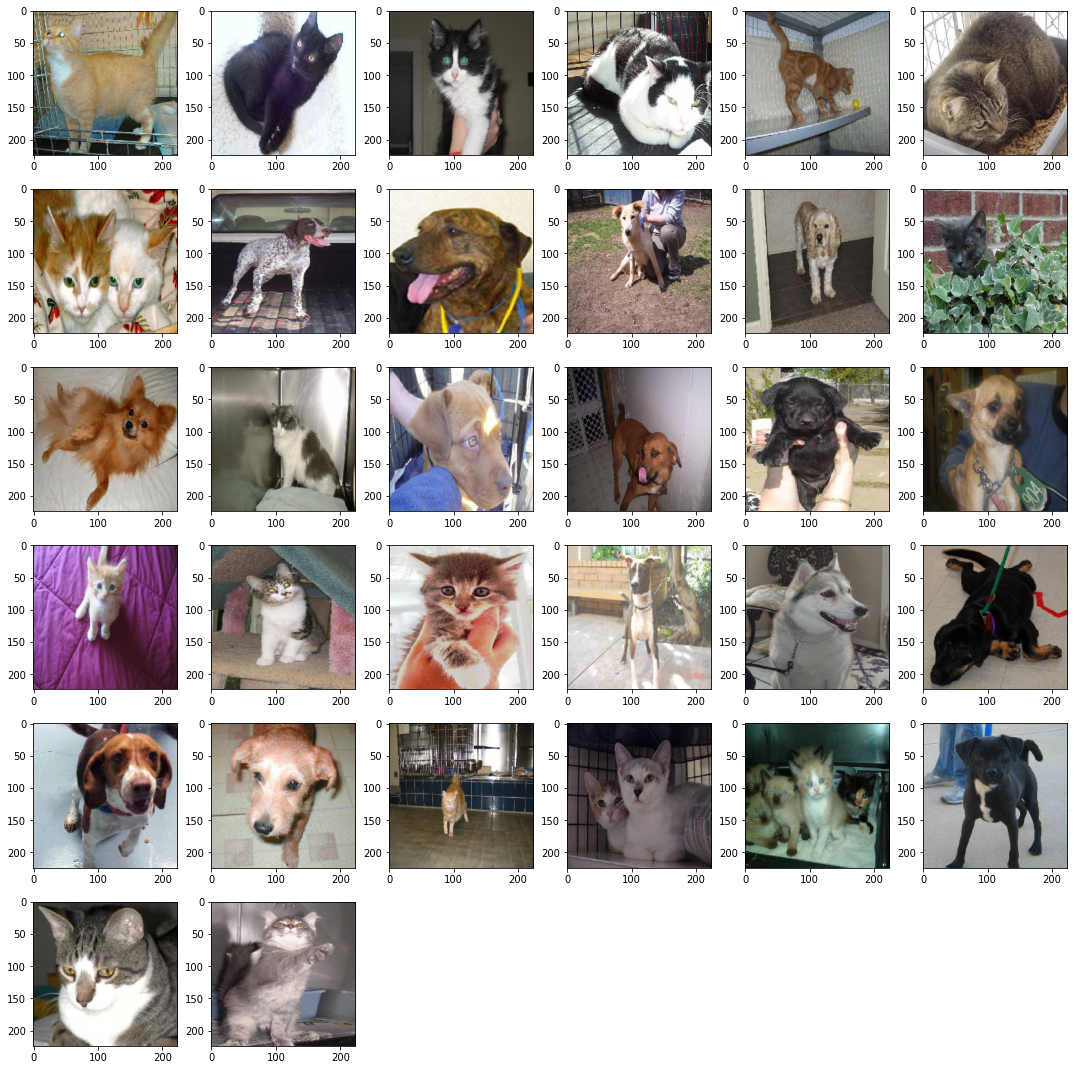

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(32):
  plt.subplot(6,6, i+1)
  plt.imshow(batch[0][i])

plt.tight_layout()
plt.show()

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

In [9]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same"))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    #2진 분류 출력: unit: 1,activation: sigmoid -> 1일 확률
    
    return model

In [21]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

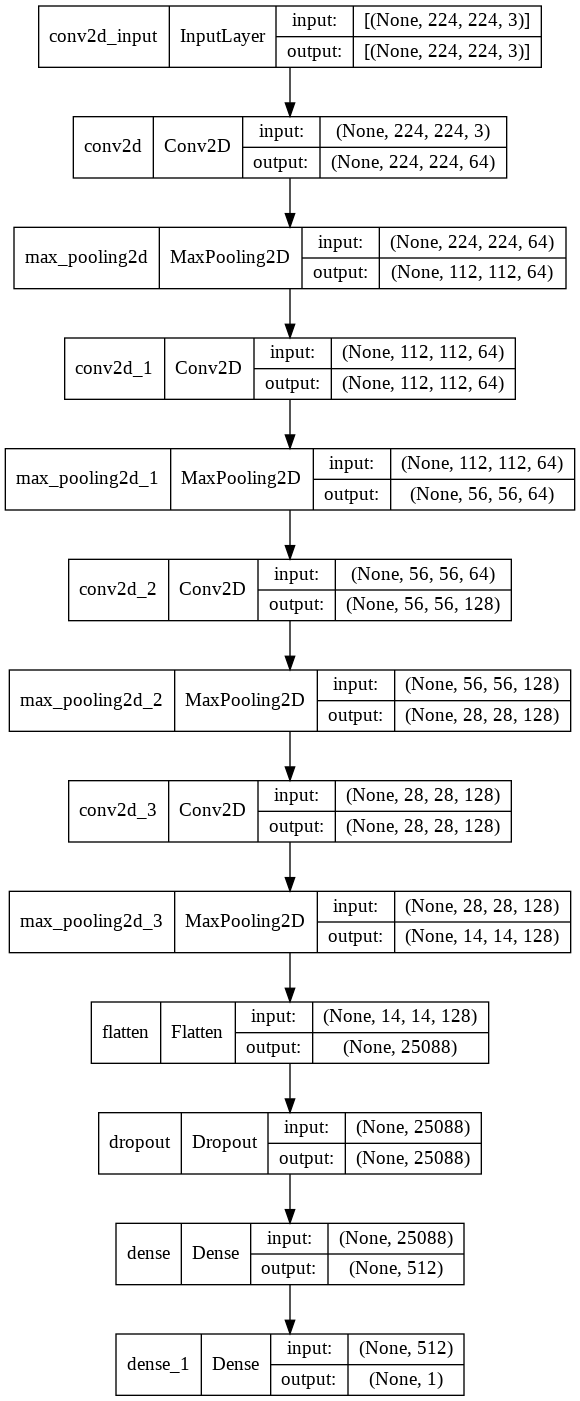

In [23]:
#입출력 확인 용이
keras.utils.plot_model(model, show_shapes=True)


##  Model Training(학습)

In [24]:
import os
save_dir = os.path.join("/content/drive/MyDrive/deeplearning", "cat_dog_model", "basic")
print(save_dir)
os.makedirs(save_dir, exist_ok=True) #exist_ok:True-이미 있는 디렉토리면 무시. False(기본)-Exception 발생
#이미 만드려고 하는 디렉토리가 있다면 그냥 넘어가라

/content/drive/MyDrive/deeplearning/cat_dog_model/basic


In [26]:
save_file_path = os.path.join(save_dir, "weights_ckpt")
#학습중 모델을 저장하는 callback - best_ㅡmodel, weights(parameter)만 저장.

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, #어디에 저장할 건지
                                              save_weights_only=True, #weight만 저장(True) 
                                              save_best_only=True, #성능이 개선될때만 저장
                                              monitor='val_loss', #모니터링할 평가지표
                                              verbose=2) #로그 남김 유무(남기겠다)

#학습중 성능이 개선되지 않으면 학습을 멈추도록 하는 callback
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", #모니터링할 평가지표 
                                            patience=10, #지정한 epoch동안 성능 개선이 안되면 멈춤
                                            verbose=1)

In [27]:
#ImageDataGenerator를 사용해 학습할 경우
#steps_per_epoch: train_dataset에 대해서 1epoch당 step 수
#validation_steps: validation dataset에 대해서 1epoch당 step 수

hist = model.fit(train_iter, 
                 epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

#에폭당 걸린 시간을 보고 싶을땐 epoch 2의 시간을 볼 것


Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.5245
Epoch 00001: val_loss improved from inf to 0.69209, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
63/63 [==============================] - 26s 245ms/step - loss: 0.7047 - accuracy: 0.5245 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5365
Epoch 00002: val_loss improved from 0.69209 to 0.68729, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
63/63 [==============================] - 14s 224ms/step - loss: 0.6917 - accuracy: 0.5365 - val_loss: 0.6873 - val_accuracy: 0.5310
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5550
Epoch 00003: val_loss did not improve from 0.68729
63/63 [==============================] - 14s 217ms/step - loss: 0.6897 - accuracy: 0.5550 - val_loss: 0.6875 - val_accurac

In [ ]:
# - train loss: 0.0743 - train accuracy: 0.9760 - val_loss: 1.1146 - val_accuracy: 0.7070


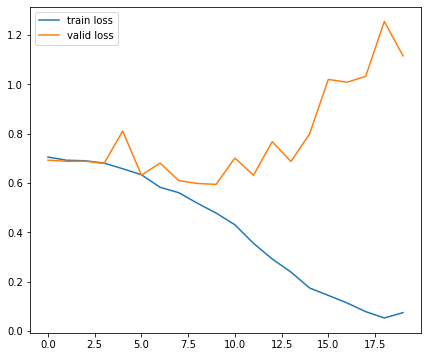

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [29]:
save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [30]:
save_model.evaluate(test_iter) #학습된 weight loading하기전에 평가

32/32 [==============================] - 4s 122ms/step - loss: 0.6933 - accuracy: 0.4950


[0.6933464407920837, 0.4950000047683716]

In [33]:
save_model.load_weights(save_file_path) #학습된 weight를 덮어씌우기(loading)

In [32]:
save_model.evaluate(test_iter) #loss: 0.6271 - accuracy: 0.6840
#validation 성능이 많이 떨어짐

32/32 [==============================] - 4s 123ms/step - loss: 0.6271 - accuracy: 0.6840


[0.6270875930786133, 0.6840000152587891]

# 새로운 데이터 추론

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_preprocess_image(img_path):
    """
    img_path 이미지를 읽어서 추론할 수있는 ndarray로 변환해서 반환하는 함수
    1. 이미지 읽기
    2. ndarray 변환
    3. shape을 모델이 추론할 수 있는 형태로 변형, 4차원(개수, h, w, c)
    """    
    raw_img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) #target_size 지정: 읽어올때
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]
    
    return (img_array/255.0).astype(np.float32) #scaling해서 반환


In [36]:
dog = load_preprocess_image('./dog.jpg')
cat = load_preprocess_image('./cat.jpg')
dog.shape, cat.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [37]:
pred1 = save_model.predict(dog)
pred2 = save_model.predict(cat)

In [40]:
print(pred1) #1일 확률
result1 = np.where(pred1>0.5, 1, 0)[0]
#result1 = np.where(pred1>0.5, 'dogs', 'cats')[0]
result1
#label은 맞췄으나 정확도는 떨어짐

[[0.56177616]]


array([1])

In [41]:
print(pred2)
result2 = np.where(pred2>0.5, 1, 0)[0]
result2

[[0.38330576]]


array([0])

In [42]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

##### 하이퍼파라미터

In [2]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224

##### ImageDataGenerator 생성

In [3]:
train_dir = 'data/cats_and_dogs_small/train'
valid_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

In [4]:
#이미지 augmentation은 train set에만 적용
train_datagen = ImageDataGenerator(rescale=1/255.0,  #scaling : 0~1
                                   rotation_range=40,  #회전 -40~40
                                   width_shift_range=0.2, #좌우로 이동 -0.2 ~0.2
                                   height_shift_range=0.2, #상하이동 -0.2~ 0.2
                                   shear_range=0.2, #전단변환 (평행사변형 모양으로 이동)
                                   zoom_range=0.2, #zooming(확대, 축소) 0.8~1.2
                                   horizontal_flip=True, #좌우반전
                                   fill_mode='constant' #변환후 생기는 공백픽셀들을 0으로 채울것.
                                   )

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [10]:
#중간에 끊겨서 데이터 다시 다운받고 압축 푼 후에 진행
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
batch_samples = next(train_iter) #배치 사이즈만큼의 값을 가져옴
print(type(batch_samples)) #(X-image, y_label)

<class 'tuple'>


In [14]:
batch_image_sample = batch_samples[0]
batch_image_sample.shape, batch_image_sample.dtype

((80, 224, 224, 3), dtype('float32'))

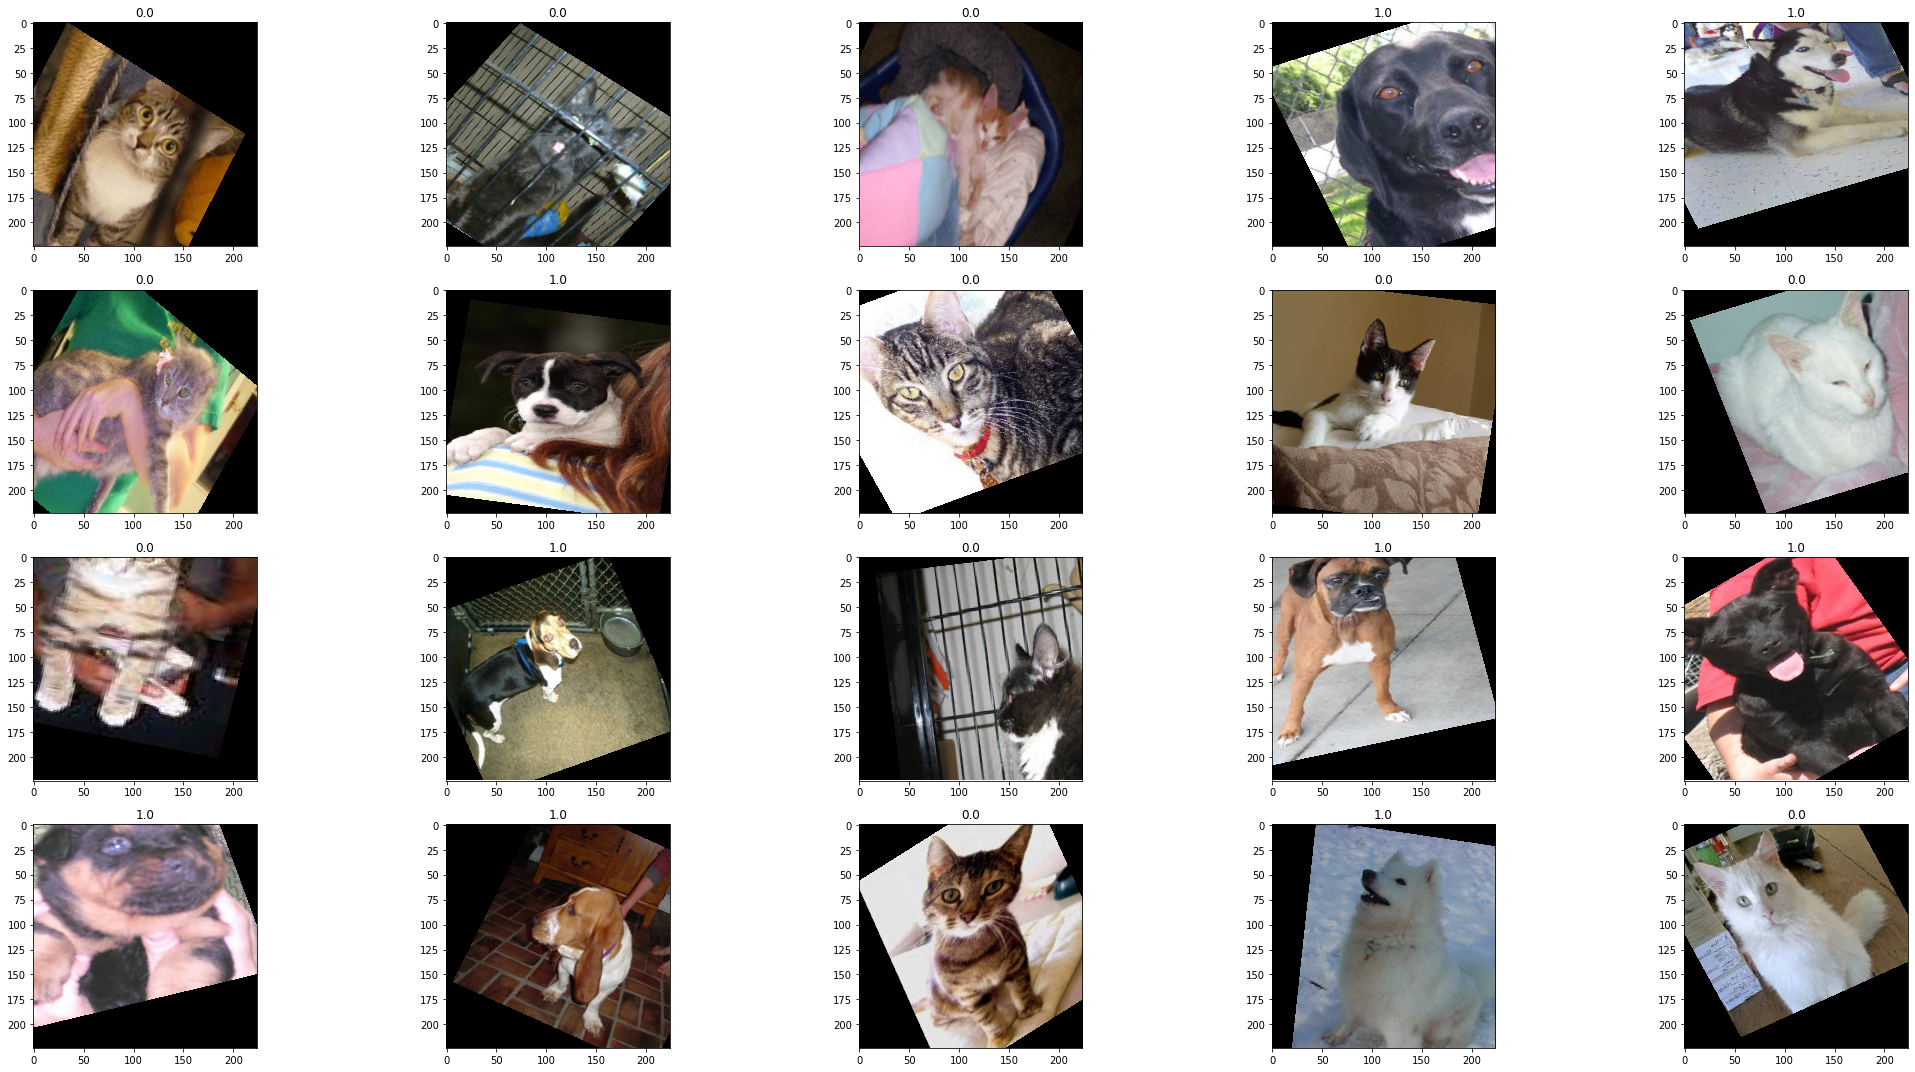

In [16]:
#iterator가 제공한 img들 확인(20장) > augmentation이 적용된 이미지들
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image_sample[i])
    plt.title(str(batch_samples[1][i]))

plt.tight_layout()
plt.show()

##### 모델 생성, 컴파일, 학습

In [ ]:
#구글 드라이브 마운트

In [18]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
save_dir = os.path.join("/content/drive/MyDrive/saved_models/cat_dog_model", "augmentation")
os.makedirs(save_dir, exist_ok=True)

In [22]:
#callback 생성
save_file_path = os.path.join(save_dir, 'weights_ckpt')


mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [23]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7496 - accuracy: 0.5030
Epoch 00001: val_loss improved from inf to 0.69506, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt
25/25 [==============================] - 46s 1s/step - loss: 0.7496 - accuracy: 0.5030 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4885
Epoch 00002: val_loss improved from 0.69506 to 0.69196, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt
25/25 [==============================] - 32s 1s/step - loss: 0.6934 - accuracy: 0.4885 - val_loss: 0.6920 - val_accuracy: 0.5070
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5405
Epoch 00003: val_loss improved from 0.69196 to 0.68228, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt
25/25 [==========

In [ ]:
"""

Epoch 00093: val_loss improved from 0.39235 to 0.37067,
saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt

#저장을 했다는 것은 성능이 좋아졌다는 것
#에폭마다 똑같은 모델을 쓰면서 이미지변환작업이 이뤄지기 때문에 매 에폭마다 시간이 다름
"""

##### 저장된 모델 Loading 후 평가(사용)

In [24]:
saved_model_aug = create_model()
saved_model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

save_file_path = '/content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt'
saved_model_aug.load_weights(save_file_path)

In [25]:
saved_model_aug.evaluate(test_iter)

13/13 [==============================] - 4s 278ms/step - loss: 0.4435 - accuracy: 0.8160


[0.4435484707355499, 0.8159999847412109]

##### 새로운데이터 추론

In [27]:
dog2 = load_preprocess_image('dog.jpg')
cat2 = load_preprocess_image('cat.jpg')

pred3 = saved_model_aug.predict(dog2)
pred4 = saved_model_aug.predict(cat2)

In [29]:
print(pred3)
np.where(pred3>=0.5, '개', '고양이') #0.5이상이면 개 아니면 고양이

[[0.99999464]]


array([['개']], dtype='<U3')

In [33]:
print(pred4)
np.where(pred4>=0.5, '개', '고양이')

[[0.2442605]]


array([['고양이']], dtype='<U3')

###  DataFrame 이용
- flow_from_dataframe() 사용
    - 파일경로와 label을 DataFrame으로 저장하고 그것을 이용해 데이터셋을 읽어온다.

In [11]:
import gdown
url = 'https://drive.google.com/uc?id=17ejPJw42TgTv0jCPMMlVTHwF57XYE2kb'
fname = 'cats_and_dogs_union.zip'
gdown.download(url, fname, quiet=True)

'cats_and_dogs_union.zip'

In [12]:
import os
from zipfile import ZipFile
ZipFile(fname).extractall(os.path.join('data','union'))

# 파일경로와 Label 정의한 DataFrame 생성
- 두 개컬럼 (파일경로-path, 라벨-label)

In [13]:
from glob import glob
#특정 디렉토리 아래에 있는 "모든파일"이나 "이름의 어떤 조건"의 파일들의 경로를 조회할 때 사용

glob(r"/content/data/union/cats/cat.0.jpg")
#파일의 경로를 주면 있는 파일일 경우 경로를 반환
glob(r"/content/data/union/cats/*.*") #모든파일
glob(r"/content/data/union/cats/*.jpg") #확장자가 jpg인 파일들 

glob(r"/content/data/union/cats/cat.1*.jpg") #이름이 cat.1로 시작. 확장자는 jpg

r=glob(r"/content/data/union/**/*.jpg") #union의 하위디렉토리에 있는 모든 jpg
#해당 디렉토리내의 파일들의 경로를 리스트로 반환
type(r)

list

In [14]:
r[:10]

['/content/data/union/dogs/dog.977.jpg',
 '/content/data/union/dogs/dog.1809.jpg',
 '/content/data/union/dogs/dog.460.jpg',
 '/content/data/union/dogs/dog.908.jpg',
 '/content/data/union/dogs/dog.1582.jpg',
 '/content/data/union/dogs/dog.330.jpg',
 '/content/data/union/dogs/dog.1902.jpg',
 '/content/data/union/dogs/dog.186.jpg',
 '/content/data/union/dogs/dog.1281.jpg',
 '/content/data/union/dogs/dog.1697.jpg']

In [15]:
#os 모듈의 함수를 이용해서 파일경로에서 특정 문자열(디렉토리, 파일명)을 추출
f='/content/data/union/cats/cat.791.jpg' #파일경로 1개
#string split
l=f.split('/')
l

['', 'content', 'data', 'union', 'cats', 'cat.791.jpg']

In [16]:
#f경로의 파일의 확장자
l = f.split('.')[-1]
l

'jpg'

In [17]:
os.path.basename(f) #f는 파일경로, 전체 경로(path)에서 마지막 경로만 추출

'cat.791.jpg'

In [18]:
os.path.dirname(f) #전체경로(path)에서 디렉토리 경로만 추출 마지막 경로 앞까지 추출
#a/b/c/d -> a/b/c

'/content/data/union/cats'

In [19]:
#파일경로에서 label 추출
#디렉토리
dir_name = os.path.dirname(f)
dir_name.split('/')[-1]

'cats'

In [20]:
#파일명 - label.번호.jpg
file_name = os.path.basename(f)
file_name.split('.')[0]

'cat'

In [21]:
#여기부터
#glob- 파일 경로를 추출하는 모듈
      #패턴문자를 이용해 여러 파일들의 경로를 쉽게 추출할 수 있음.
      #디렉토리:** - 모든 하위 디렉토리를 의미
      #파일:* - 모든 글자
from glob import glob
path_list = glob('/content/data/union/**/*.jpg')
type(path_list), len(path_list)

(list, 4000)

In [22]:
path_list[-10:]

['/content/data/union/cats/cat.1411.jpg',
 '/content/data/union/cats/cat.353.jpg',
 '/content/data/union/cats/cat.939.jpg',
 '/content/data/union/cats/cat.897.jpg',
 '/content/data/union/cats/cat.1391.jpg',
 '/content/data/union/cats/cat.1673.jpg',
 '/content/data/union/cats/cat.1510.jpg',
 '/content/data/union/cats/cat.1610.jpg',
 '/content/data/union/cats/cat.1430.jpg',
 '/content/data/union/cats/cat.664.jpg']

In [23]:
label_list =[]
for path in path_list:
  label= os.path.basename(path).split('.')[0] #파일명에서 label 추출
  label_list.append(label)

In [24]:
len(label_list), label_list[-10:]

(4000, ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'])

In [25]:
label_list2 = [os.path.basename(path).split('.')[0] for path in path_list]
label_list2[:10], len(label_list2)

(['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog'], 4000)

In [26]:
import pandas as pd
d = {
    'path':path_list,
    'label':label_list
}
df = pd.DataFrame(d)
df.shape

(4000, 2)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    4000 non-null   object
 1   label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [28]:
df.describe()

,path,label
count,4000,4000
unique,4000,2
top,/content/data/union/cats/cat.1621.jpg,cat
freq,1,2000


In [29]:
df['label'].value_counts()

cat    2000
dog    2000
Name: label, dtype: int64

In [30]:
df.head()

,path,label
0,/content/data/union/dogs/dog.977.jpg,dog
1,/content/data/union/dogs/dog.1809.jpg,dog
2,/content/data/union/dogs/dog.460.jpg,dog
3,/content/data/union/dogs/dog.908.jpg,dog
4,/content/data/union/dogs/dog.1582.jpg,dog


In [31]:
df.tail()

,path,label
3995,/content/data/union/cats/cat.1673.jpg,cat
3996,/content/data/union/cats/cat.1510.jpg,cat
3997,/content/data/union/cats/cat.1610.jpg,cat
3998,/content/data/union/cats/cat.1430.jpg,cat
3999,/content/data/union/cats/cat.664.jpg,cat


In [32]:
df.to_csv('cat_dog_path.cvs', index=False)

# train/test/validation set으로 나누기.

In [33]:
#label 별로 두개의 DataFrame을 생성
cat_df = df[df['label']=='cat']

dog_df = df[df['label']=='dog']
cat_df.shape, dog_df.shape

((2000, 2), (2000, 2))

In [34]:
print(cat_df['label'].value_counts())
dog_df['label'].value_counts()

cat    2000
Name: label, dtype: int64


dog    2000
Name: label, dtype: int64

In [35]:
#2000개 중, 1600는 train, 400 test
idx = 1600
train_df = pd.concat([cat_df.iloc[:idx], dog_df.iloc[:idx]], axis=0) #행기준 합침

test_df = pd.concat([cat_df.iloc[idx:], dog_df.iloc[idx:]], axis=0) 

train_df.shape, test_df.shape

((3200, 2), (800, 2))

In [36]:
train_df['label'].value_counts()

cat    1600
dog    1600
Name: label, dtype: int64

In [37]:
test_df['label'].value_counts()

cat    400
dog    400
Name: label, dtype: int64

In [38]:
train_df.to_csv('cat_dog_path_train.csv', index=False)
test_df.to_csv('cat_dog_path_test.csv', index=False)

In [39]:
train_df.head()

,path,label
2000,/content/data/union/cats/cat.953.jpg,cat
2001,/content/data/union/cats/cat.1488.jpg,cat
2002,/content/data/union/cats/cat.280.jpg,cat
2003,/content/data/union/cats/cat.1018.jpg,cat
2004,/content/data/union/cats/cat.243.jpg,cat


In [40]:
train_df.tail()

,path,label
1595,/content/data/union/dogs/dog.1937.jpg,dog
1596,/content/data/union/dogs/dog.1132.jpg,dog
1597,/content/data/union/dogs/dog.1646.jpg,dog
1598,/content/data/union/dogs/dog.962.jpg,dog
1599,/content/data/union/dogs/dog.253.jpg,dog


# ImageDataGenerator 생성

In [41]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   brightness_range=[0.7, 1.3], #밝기 조절
                                   fill_mode='constant')

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [42]:
train_iter = train_datagen.flow_from_dataframe(train_df, #경로/라벨이 있는 DataFrame 객체
                                               x_col="path", #경로 컬럼명 
                                               y_col='label', #label 컬럼명
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS
                                               )

valid_iter = valid_datagen.flow_from_dataframe(test_df,
                                               x_col="path",
                                               y_col='label',
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [43]:
train_iter.class_indices

{'cat': 0, 'dog': 1}

##### 모델 생성, 컴파일

In [44]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
es_callback = keras.callbacks.EarlyStopping(patience=10, verbose=2)

In [46]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[es_callback])

Epoch 1/100
100/100 [==============================] - 59s 546ms/step - loss: 0.7016 - accuracy: 0.5084 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 54s 536ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/100
100/100 [==============================] - 54s 539ms/step - loss: 0.6926 - accuracy: 0.5225 - val_loss: 0.6893 - val_accuracy: 0.4975
Epoch 4/100
100/100 [==============================] - 53s 527ms/step - loss: 0.6938 - accuracy: 0.4959 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 5/100
100/100 [==============================] - 53s 531ms/step - loss: 0.6910 - accuracy: 0.5306 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/100
100/100 [==============================] - 53s 527ms/step - loss: 0.6936 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
100/100 [==============================] - 53s 530ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 -